## Read Data from Subjects 

In [27]:
import pandas as pd

# =  pd.read_csv('data/subjects/exp_yn.csv')
data =  pd.read_csv('data/subjects/r_word_3/r_word_3_final.csv')

In [28]:
data.dtypes

Subject       object
Date_Time     object
CH_1_mV      float64
CH_2_mV      float64
CH_3_mV      float64
CH_4_mV      float64
Target        object
dtype: object

In [29]:
data[10305:10313]

,Subject,Date_Time,CH_1_mV,CH_2_mV,CH_3_mV,CH_4_mV,Target
10305,r_word_3,2019-03-13 20:20:33.473990,0.142032,1.688463,-0.453453,17.808777,relax
10306,r_word_3,2019-03-13 20:20:33.474062,0.137728,1.698368,-0.429388,17.786251,relax
10307,r_word_3,2019-03-13 20:20:33.478503,0.091450,1.677741,-0.459102,17.785386,relax
10308,r_word_3,2019-03-13 20:20:33.478683,0.122727,1.692839,-0.477493,17.803368,relax
10309,r_word_3,2019-03-13 20:20:33.478773,0.080560,1.701421,-0.481003,17.784016,relax
10310,r_word_3,2019-03-13 20:20:33.478875,0.079430,1.623025,-0.474296,17.797238,relax
10311,r_word_3,2019-03-13 20:20:33.497568,0.066256,1.757460,-0.465641,17.778294,relax
10312,r_word_3,2019-03-13 20:20:33.497768,0.118784,1.718610,-0.463430,17.790459,relax


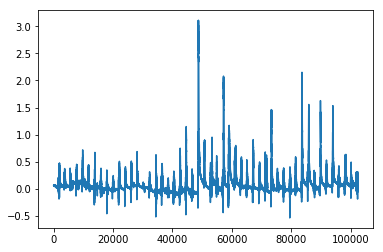

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Right Jaw 
plt.plot('CH_1_mV', data = data)
plt.show()

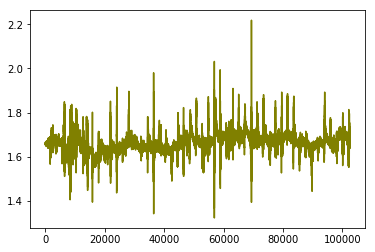

In [31]:
# Left Cheeck
plt.plot('CH_2_mV', data= data,  color='olive')
plt.show()

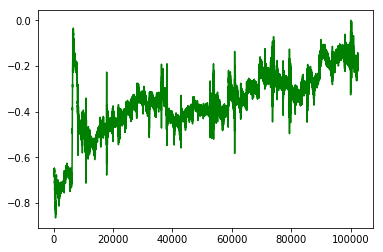

In [32]:
# Throat
plt.plot('CH_3_mV', data= data,  color='green')
plt.show()

In [12]:
print('max:', data['CH_1_mV'].max())
print('min:', data['CH_1_mV'].min())

max: 9.030853990418194
min: 8.444697472814418


## Determine frequencies 

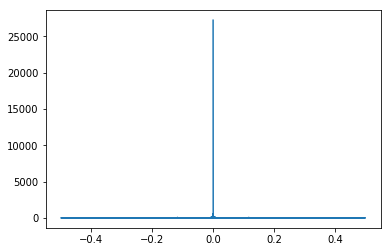

In [19]:
import numpy.fft as fft

# Choose signal 
orig_signal = data['CH_3_mV']

#calculate fourier transform 
spectrum = fft.fft(orig_signal)

#plot the magnitudes 
freq = fft.fftfreq(len(spectrum))
plt.plot(freq, abs(spectrum))
plt.show()

In [1]:
abs(spectrum)

NameError: name 'spectrum' is not defined

In [17]:
max_y = max(abs(spectrum))  # Find the maximum y value
min_y = min(abs(spectrum))
max_x = freq[list(abs(spectrum)).index(max_y)]  # Find the x value corresponding to the maximum y value
min_x = freq[list(abs(spectrum)).index(min_y)]  # Find the x value corresponding to the maximum y value

print('max:', max_x)
print('min:', min_x)

ValueError: nan is not in list

## Envelope of Signal 

In [40]:
def getEnvelope (inputSignal):

    # Taking the absolute value

    absoluteSignal = []
    for sample in inputSignal:
        absoluteSignal.append (abs (sample))

    # Peak detection

    intervalLength = 100# Experiment with this number, it depends on your sample frequency and highest "whistle" frequency
    outputSignal = []

    for baseIndex in range (intervalLength, len (absoluteSignal)):
        maximum = 0
        for lookbackIndex in range(intervalLength):
            maximum = max (absoluteSignal [baseIndex - lookbackIndex], maximum)
        outputSignal.append (maximum)

    return outputSignal

## Bandpass filter

In [41]:
import numpy as np
import scipy

from scipy import signal

def band_pass(fL, fH, b):
    '''
    :param fL: lower frequency 
    :param fH: higher frequency
    :param b: bandwidth
    :return: bandpass filter
    '''
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1# making odd
    n = np.arange(N)

    # low-pass filter
    hlpf = np.sinc(2 * fH * (n - (N - 1) / 2.))
    hlpf *= np.blackman(N)
    hlpf = hlpf / np.sum(hlpf)

    # high-pass filter 
    hhpf = np.sinc(2 * fL * (n - (N - 1) / 2.))
    hhpf *= np.blackman(N)
    hhpf = hhpf / np.sum(hhpf)
    hhpf = -hhpf
    hhpf[int((N - 1) / 2)] += 1

    h = np.convolve(hlpf, hhpf)
    return h


## High Pass Filter 

In [42]:
def high_pass(fc,b):
    '''
    :param fc: cutoff frequency
    :param b: bandwidth
    :return: high pass filter
    '''
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = np.blackman(N)
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    # reverse function
    sinc_func = -sinc_func
    sinc_func[int((N - 1) / 2)] += 1
    return sinc_func


## Low Pass Filter 

In [43]:
def low_pass(fc, b):
    '''
    :param fc: cutoff frequency
    :param b: bandwidth
    :return: low pass filter
    '''
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)
    return sinc_func


## CWT Features 

### Original Singals

In [44]:
# deterime value ranges for targets 
import more_itertools as mit

not_relax = data[data['Target'] != 'relax'].index.tolist()
groups = [list(group) for group in mit.consecutive_groups(not_relax)]

In [45]:
for i in groups:
    print(min(i),max(i))

391 762
3036 3964
4239 4703
5183 5683
6156 7388
8413 8857
9295 9821
10309 10815
11772 12806
13728 14022
14476 15007
15487 16219
17254 18277
19138 19458
19908 20439
21020 21775
22811 23820
24692 24983
25469 25965
26516 27291
28319 29339
29821 30235
30698 31208
31727 32754
33779 34646


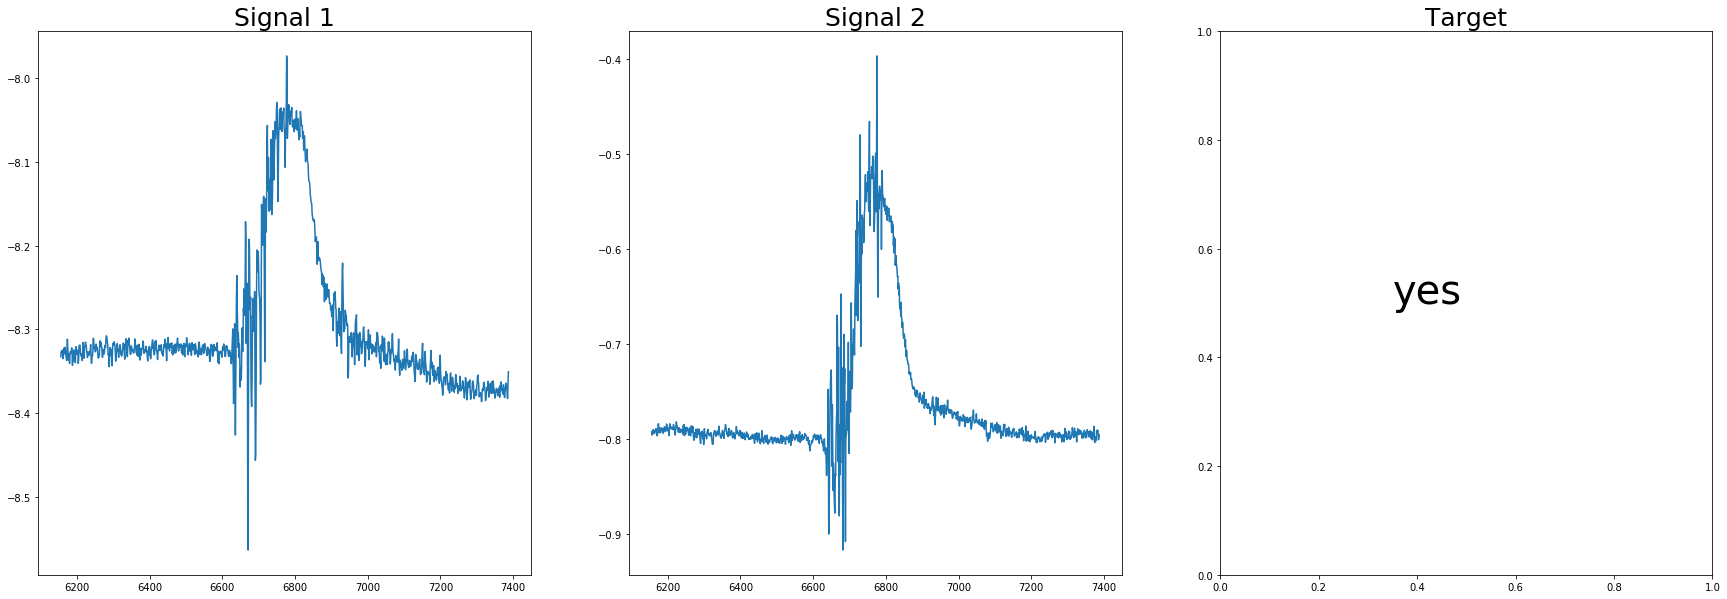

In [46]:
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.plot(data['CH_1_mV'][min(groups[4]):max(groups[4])])
plt.title('Signal 1', {'fontsize': 25})

                      
plt.subplot(1,3,2)
plt.plot(data['CH_2_mV'][min(groups[4]):max(groups[4])])
plt.title('Signal 2', {'fontsize': 25})


plt.subplot(1,3,3)
plt.text(0.35, 0.5, data.iloc[min(groups[4]) + 10]['Target'] , dict(size=40))
plt.title('Target', {'fontsize': 25})

                         
plt.show()  

## Filterd Signals 

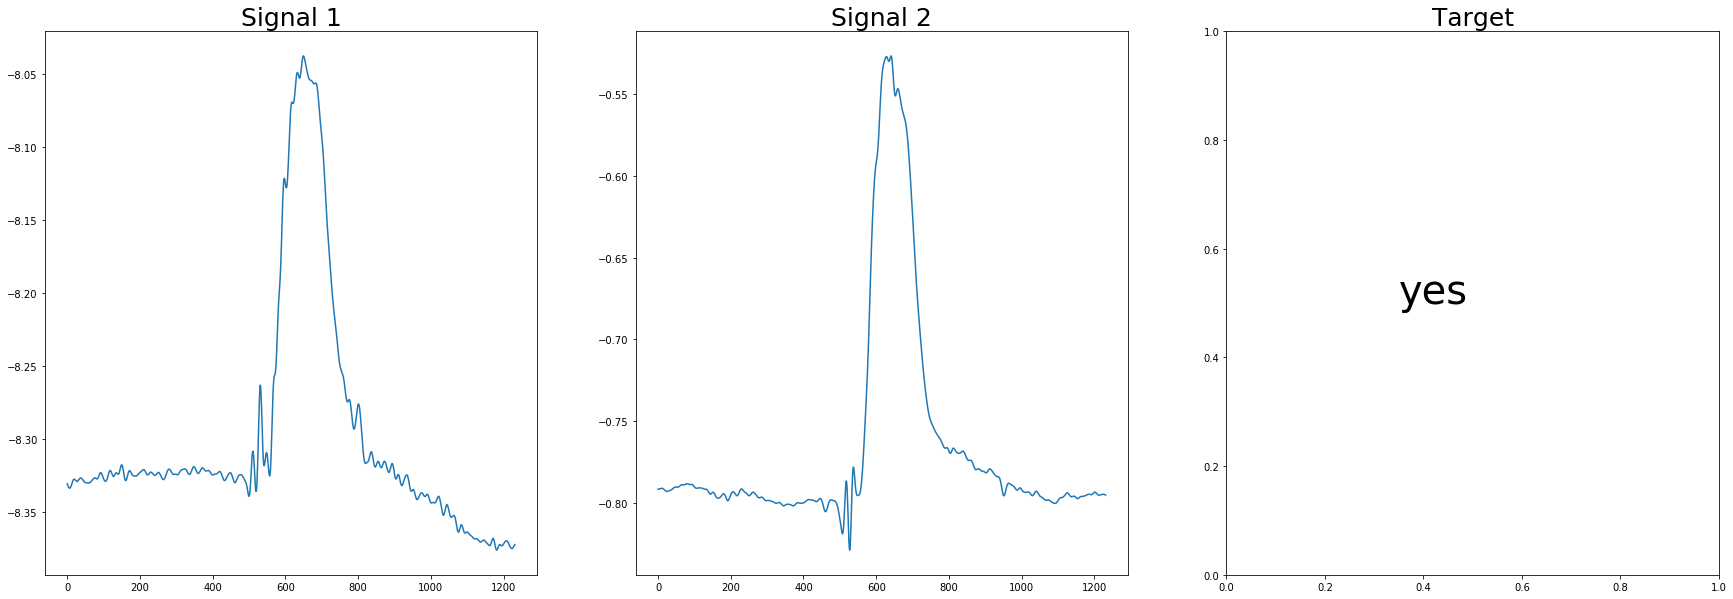

In [47]:
# use the plot function
lp_filter = low_pass(0.05,0.08)

plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
ch1 = np.convolve(data['CH_1_mV'], lp_filter)
plt.plot(ch1[min(groups[4]):max(groups[4])])
plt.title('Signal 1', {'fontsize': 25})


plt.subplot(1,3,2)
ch2 = np.convolve(data['CH_2_mV'], lp_filter)
plt.plot(ch2[min(groups[4]):max(groups[4])])
plt.title('Signal 2', {'fontsize': 25})


plt.subplot(1,3,3)
plt.text(0.35, 0.5, data.iloc[min(groups[4]) + 10]['Target'] , dict(size=40))
plt.title('Target', {'fontsize': 25})


plt.show() 

## Create Continous Wavelet Transform 

In [48]:
 def create_plots(rows,data):
    '''
    :param rows: rows from ranges of taget values 
    :param data: data frame to use
    :return: plot of sigals, cwt and target response 
    '''
    
    max_w = 30
    
    widths = np.arange(1,max_w)
    
    plt.figure(figsize=(25,5))

    plt.subplot(1,5,1)
    plt.plot(ch1[min(rows):max(rows)])

    plt.subplot(1,5,2)
    cwtmatr = signal.cwt(ch1[min(rows):max(rows)], signal.ricker, widths)
    plt.imshow(cwtmatr, extent=[-1, 1, 1, max_w], cmap='hsv', aspect='auto',
               vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

    plt.subplot(1,5,3)
    plt.plot(ch2[min(rows):max(rows)])

    plt.subplot(1,5,4)
    cwtmatr = signal.cwt(ch2[min(rows):max(rows)], signal.ricker, widths)
    plt.imshow(cwtmatr, extent=[-1, 1, 1, max_w], cmap='hsv', aspect='auto',
               vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    
    plt.subplot(1,5,5)
    plt.text(0.35, 0.5, data.iloc[min(rows) + 10]['Target'] , dict(size=30))
    
    plt.show()

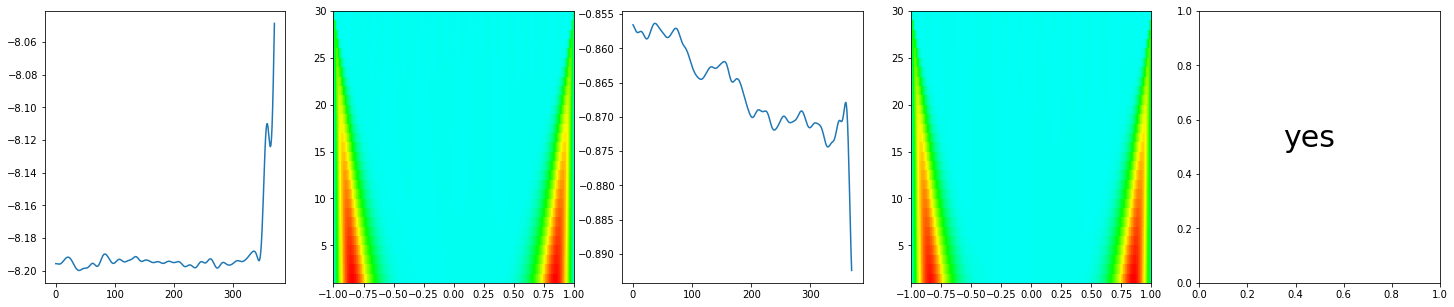

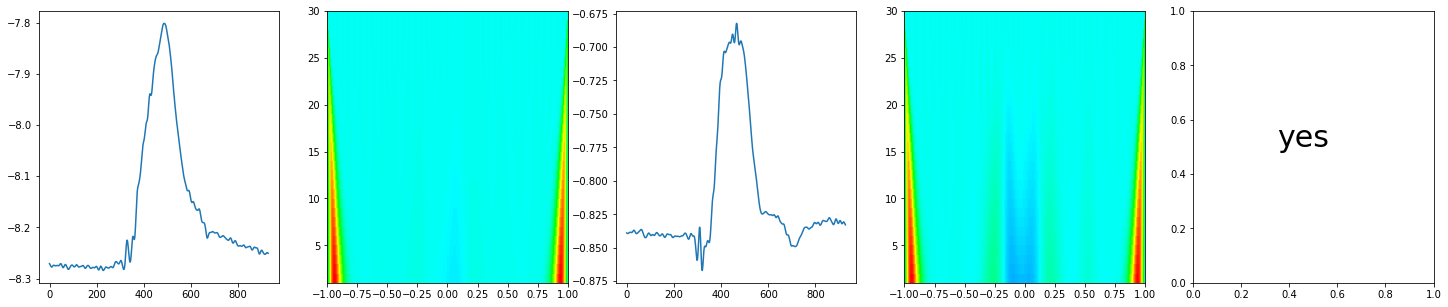

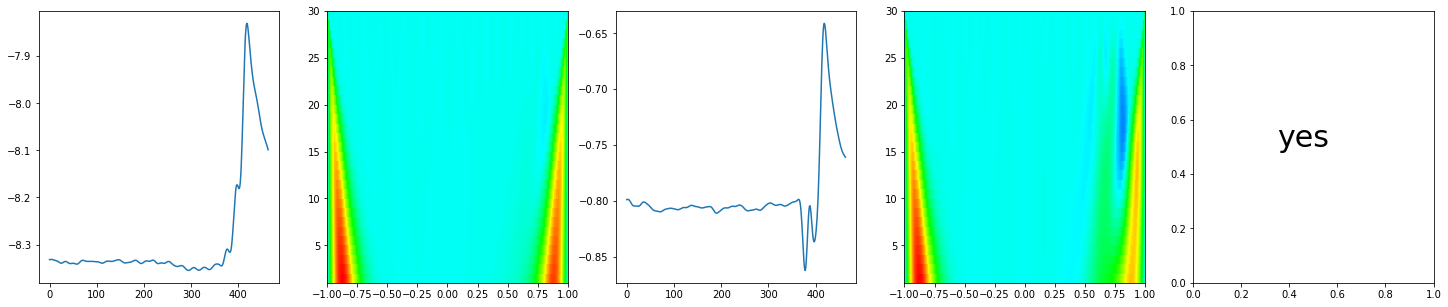

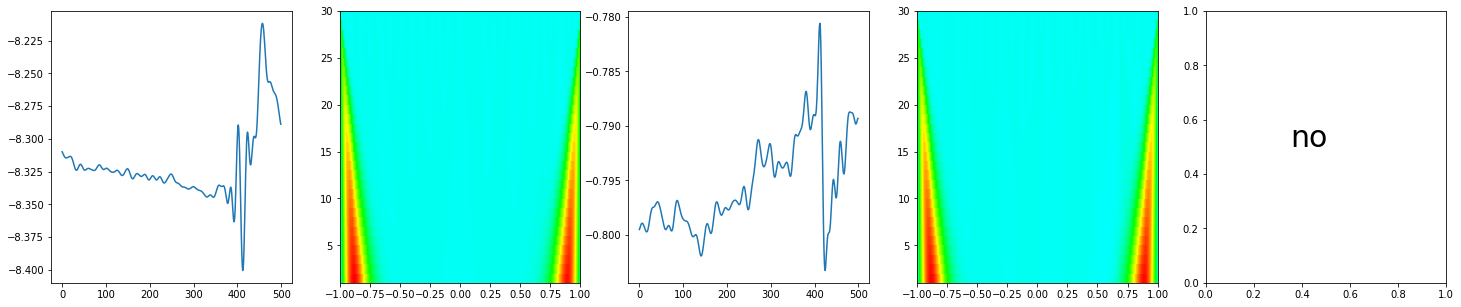

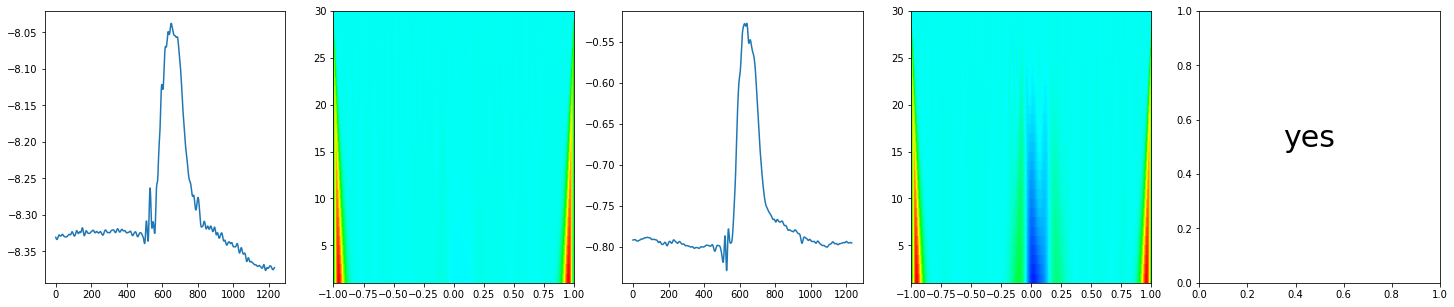

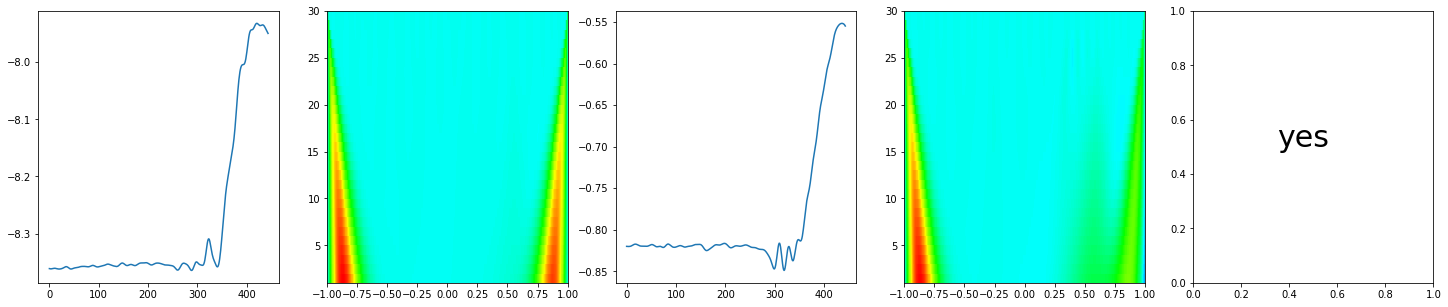

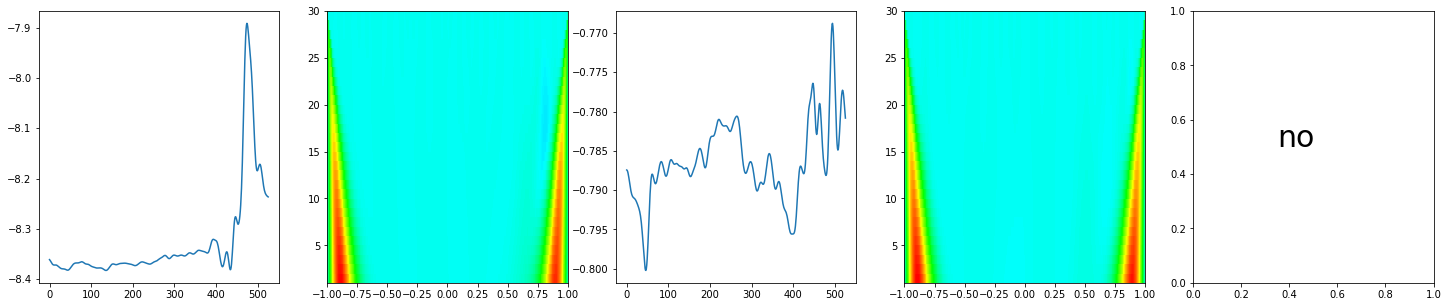

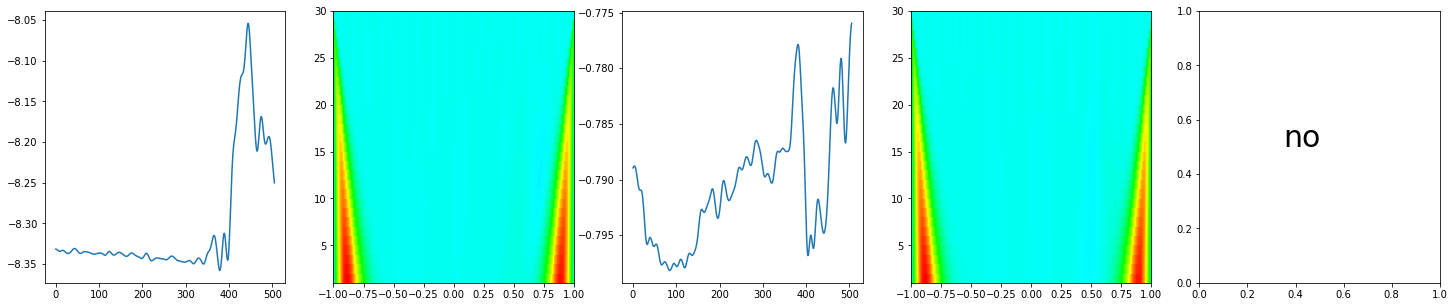

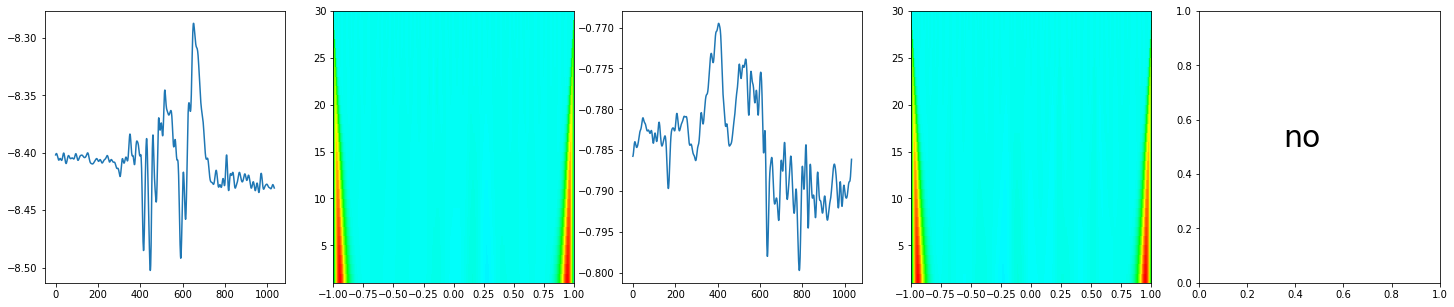

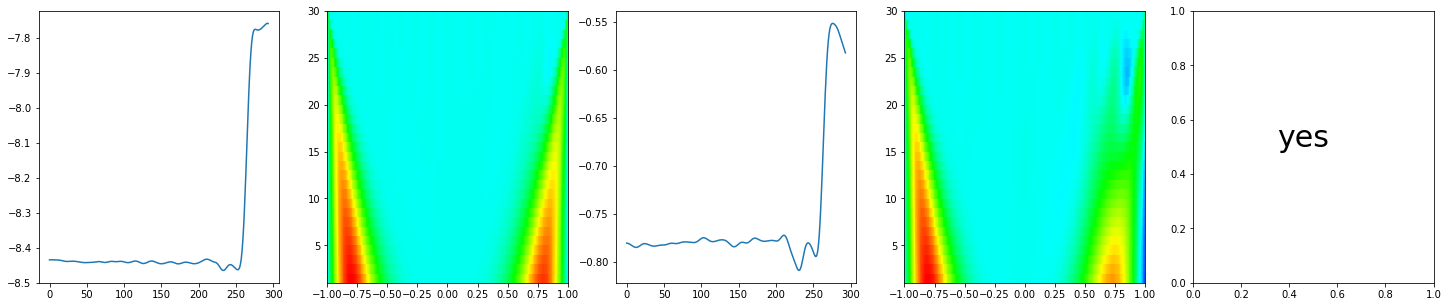

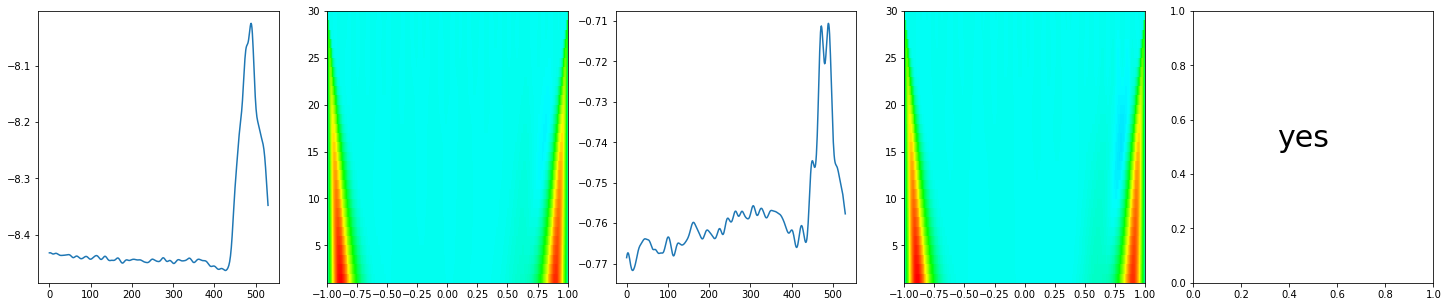

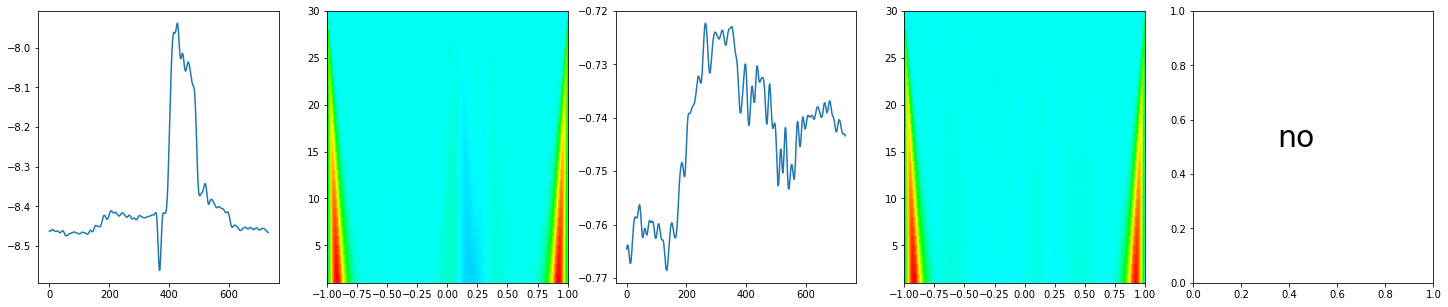

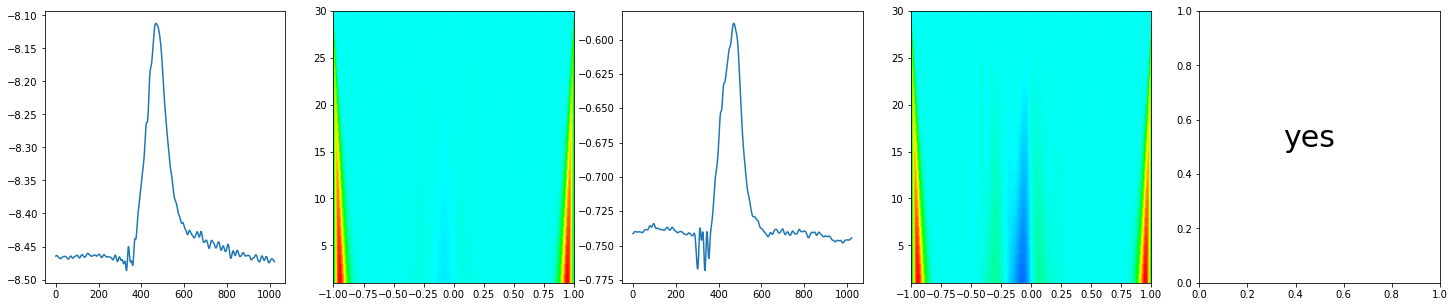

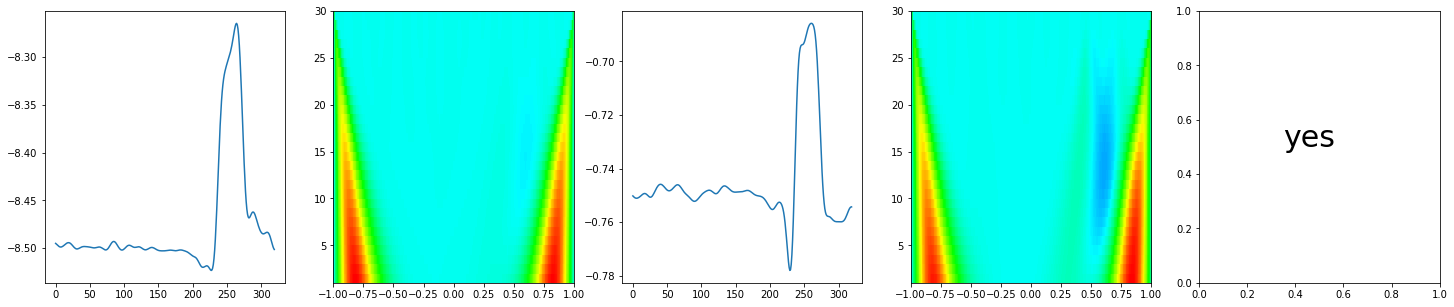

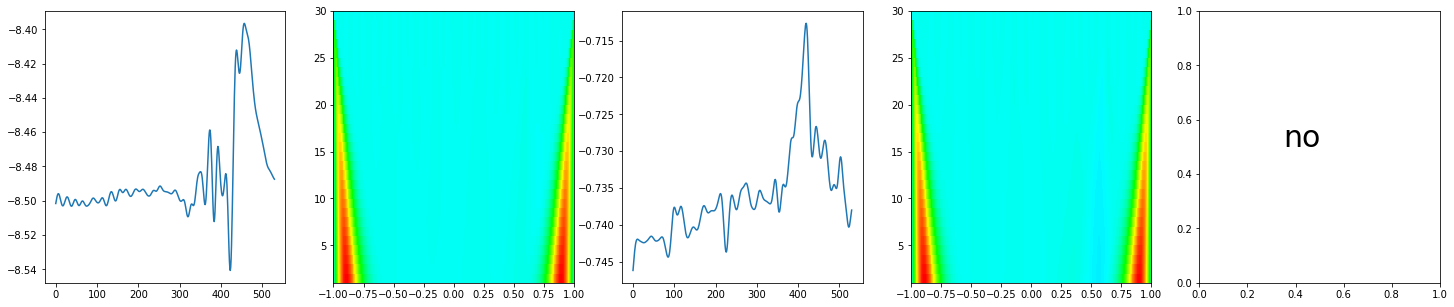

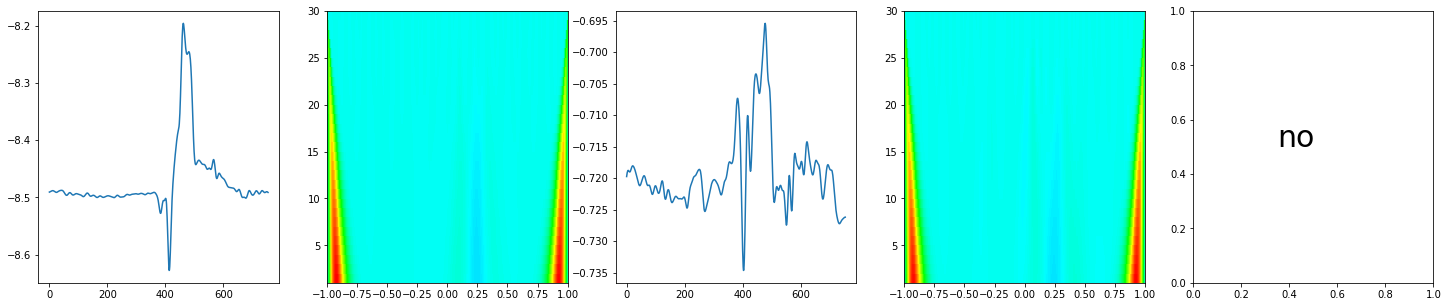

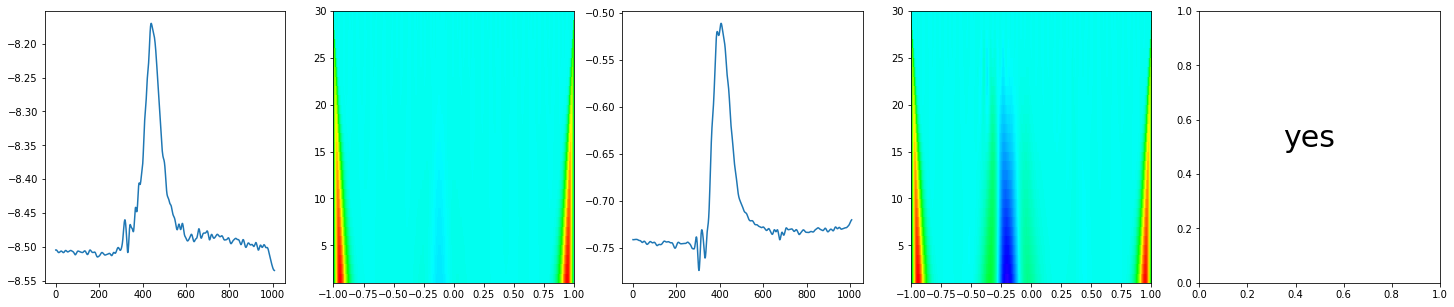

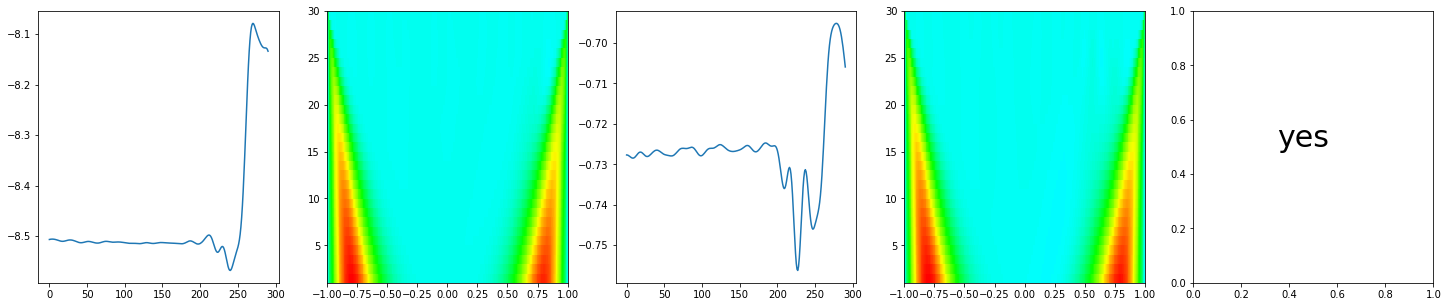

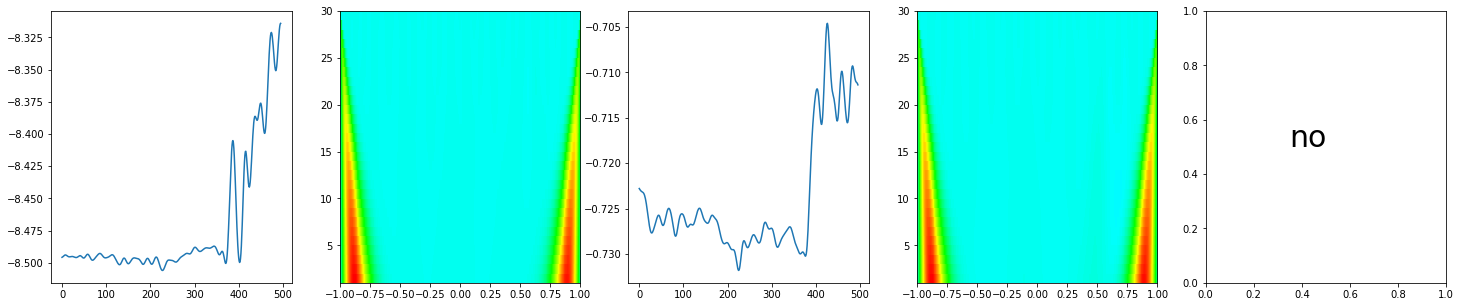

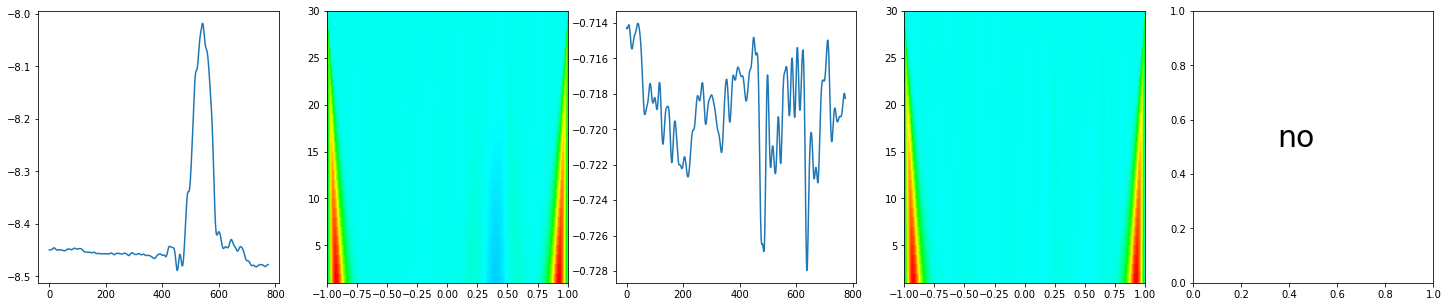

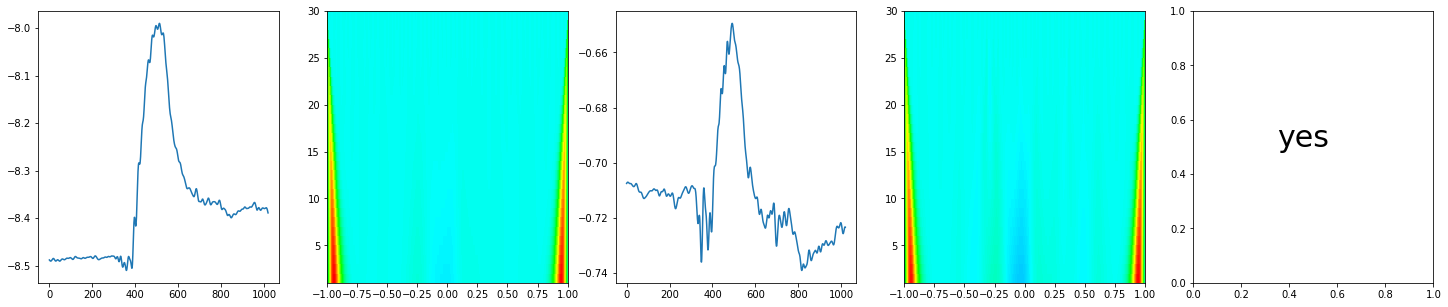

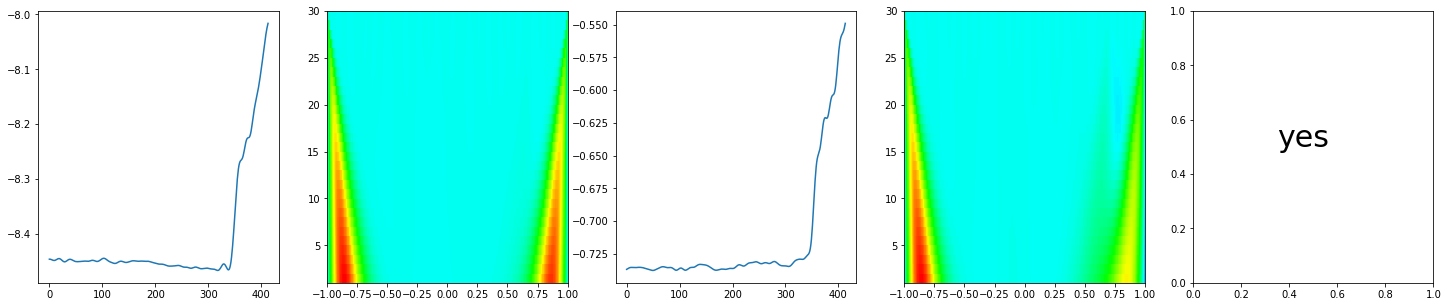

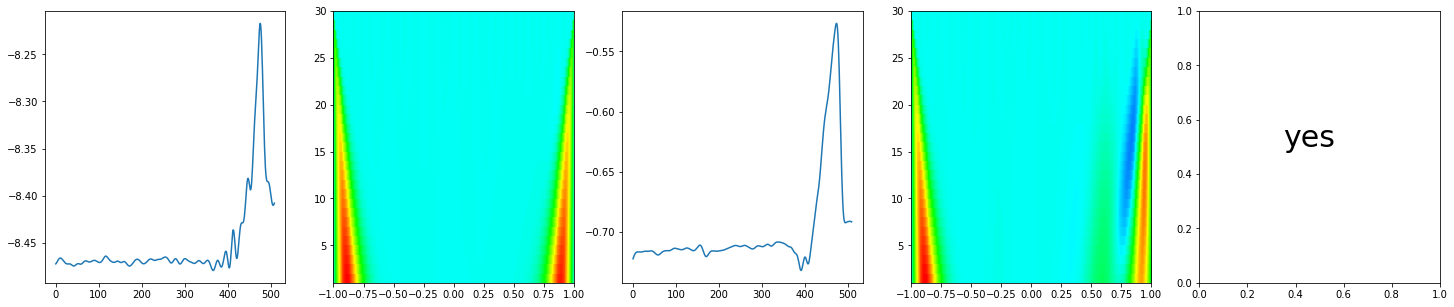

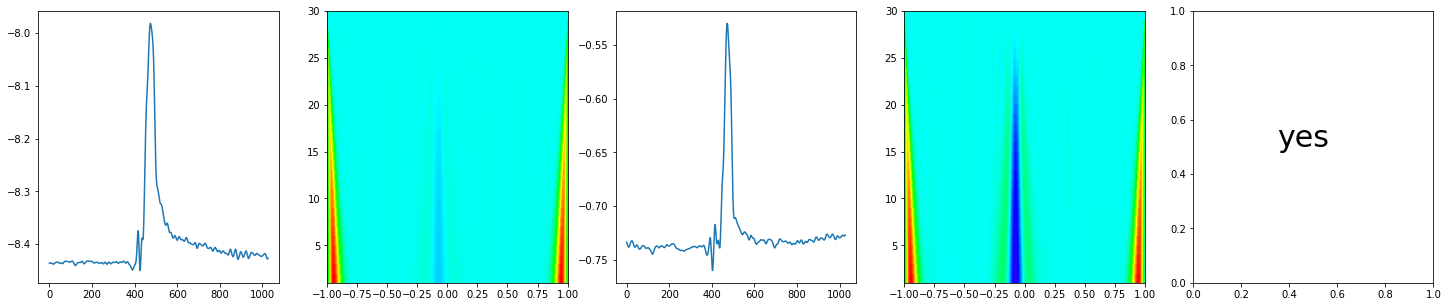

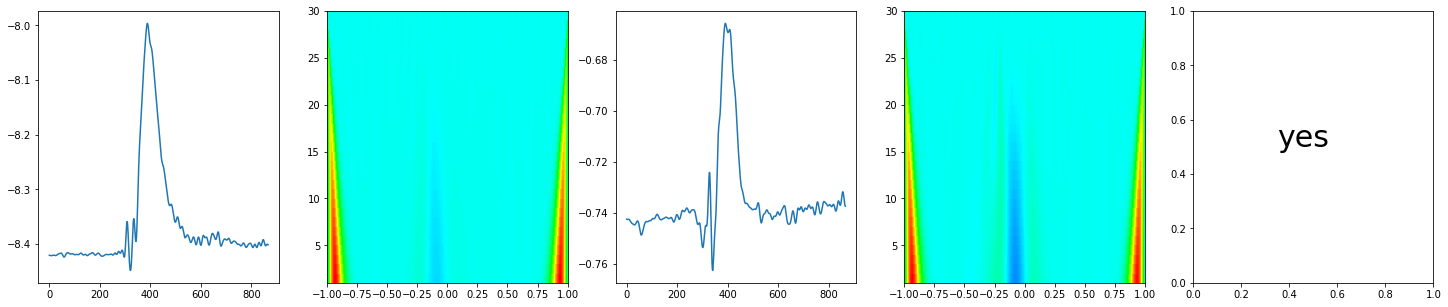

In [49]:
# Plot Results 
for rows in groups:
    create_plots(rows,data)

## Next Steps 
* Determine better options for CWT Figures 
* Get more Data 
* Implement multi-input CNN

![title](images/multi-input-multi-output-graph.png 'multi-input keras' )